# IT Industry

Import libraries

In [ ]:
%pip install quandl

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import quandl

In [ ]:
%pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 25.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
#from sklearn.metrics import mean_absolute_percentage_error as mape, 
from functools import reduce
from dateutil.relativedelta import relativedelta

## Target Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load PE ratio data from Capital IQ

In [ ]:
pe_df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/IT_PE_daily_normalized.xlsx')
pe_df=pe_df.rename(columns={'Dates': 'Date'})
pe_df=pe_df.rename(columns={'S&P 500 Information Technology (Sector) (^SP500-45) - P/Normalized EPS': 'PE'})
pe_df['Date']=pd.to_datetime(pe_df['Date'])
pe_df=pe_df.set_index('Date')
pe_df.head()

,PE
Date,
2001-08-23,59.042834
2001-08-24,63.403021
2001-08-27,63.498472
2001-08-28,61.720208
2001-08-29,60.543478


Load Price data from Capital IQ

In [ ]:
price=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/IT_daily_price.xlsx')
price=price.rename(columns={'Dates': 'Date'})
price=price.rename(columns={'S&P 500 Information Technology (Sector) (^SP500-45) - Index Value': 'Price'})
price['Date']=pd.to_datetime(price['Date'])
price=price.set_index('Date')
price.head()

,Price
Date,
2001-08-01,383.611669
2001-08-02,391.094138
2001-08-03,386.390334
2001-08-06,379.604530
2001-08-07,377.275542


Load 10 year treasury rate from Quandl

In [ ]:
quandl.ApiConfig.api_key='91nyd8SyzTFzVtMSfKPJ'
treasury=quandl.get('FRED/DGS10')
treasury['Date']=treasury.index
treasury['Date']=pd.to_datetime(treasury['Date'])
treasury=treasury.rename(columns={'Value': 'Treasury'})
treasury=treasury.reset_index(drop=True)
treasury=treasury.set_index('Date')
treasury.head()

,Treasury
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


Transformation

In [ ]:
target=pe_df.join(price).join(treasury)
target
target['Year']=target.index.year
target['Month']=target.index.month
target=target.groupby([target['Year'], target['Month']]).mean()
target.head()

PE       Price  Treasury
Year Month                                  
2001 8       60.572125  339.866799  4.861429
     9       51.451013  279.650007  4.748667
     10      60.709621  300.062071  4.566818
     11      95.584733  349.391499  4.651500
     12     114.613352  365.448987  5.087500

In [ ]:
target=target.reset_index()
target['Date']=pd.to_datetime(target[['Year', 'Month']].assign(DAY=1))
target=target.set_index('Date')
target.head()

,Year,Month,PE,Price,Treasury
Date,,,,,
2001-08-01,2001,8,60.572125,339.866799,4.861429
2001-09-01,2001,9,51.451013,279.650007,4.748667
2001-10-01,2001,10,60.709621,300.062071,4.566818
2001-11-01,2001,11,95.584733,349.391499,4.651500
2001-12-01,2001,12,114.613352,365.448987,5.087500


In [ ]:
target['Earnings']=target['Price']/target['PE']
target['earnings_change']=target['Earnings'].pct_change()
target['Target']=target['earnings_change'] - ((1 + target['Treasury']/100)**(1/12) - 1)
target=target.dropna()
target.head()

,Year,Month,PE,Price,Treasury,Earnings,earnings_change,Target
Date,,,,,,,,
2001-09-01,2001,9,51.451013,279.650007,4.748667,5.435267,-0.031310,-0.035183
2001-10-01,2001,10,60.709621,300.062071,4.566818,4.942579,-0.090647,-0.094375
2001-11-01,2001,11,95.584733,349.391499,4.651500,3.655307,-0.260445,-0.264241
2001-12-01,2001,12,114.613352,365.448987,5.087500,3.188538,-0.127696,-0.131840
2002-01-01,2002,1,142.258870,365.618474,5.035714,2.570093,-0.193959,-0.198061


In [ ]:
Target=target[['Target']]
Target['Date']=Target.index
Target.head()

,Target,Date
Date,,
2001-09-01,-0.035183,2001-09-01
2001-10-01,-0.094375,2001-10-01
2001-11-01,-0.264241,2001-11-01
2001-12-01,-0.131840,2001-12-01
2002-01-01,-0.198061,2002-01-01


Text(0.5, 1.0, 'Annualized EPS Growth Rate Minus 10-year Treasury Yield For IT Industry')

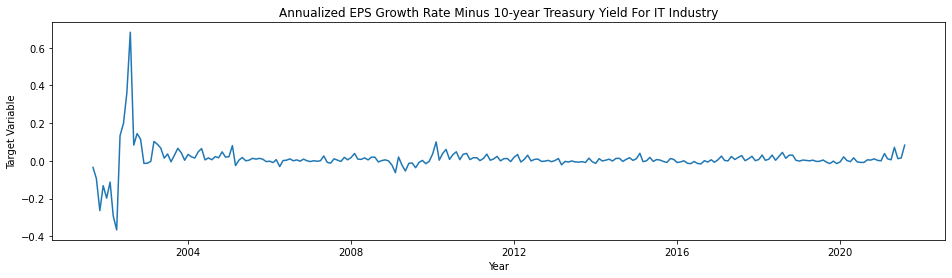

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(16,4))
plt.plot(Target['Date'],Target['Target'])
ax.set_xlabel('Year')
ax.set_ylabel('Target Variable')
ax.set_title('Annualized EPS Growth Rate Minus 10-year Treasury Yield For IT Industry')

## Independent Variables

### Data download and manipulation with Quandl

In [ ]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')
    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])
    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']
    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']
    df_final = pd.DataFrame(df_mom_ch)#.join(df_yoy_ch).join(df)   
    return df_final

Private fixed investment: Nonresidential: Intellectual property products: Software

In [ ]:
ipr=quandl.get('FRED/B985RC1Q027SBEA')
ipr.head()

,Value
Date,
1959-01-01,0.007
1959-04-01,0.005
1959-07-01,0.011
1959-10-01,0.032
1960-01-01,0.076


Value of Manufacturers' Shipments for Information Technology Industries

In [ ]:
shipment=quandl.get('FRED/AITIVS')
shipment.head()

,Value
Date,
1992-01-01,19475.0
1992-02-01,19049.0
1992-03-01,19366.0
1992-04-01,20185.0
1992-05-01,19937.0


Value of Manufacturers' New Orders for Information Technology Industries

In [ ]:
orders=quandl.get('FRED/AITINO')
orders.head()

,Value
Date,
1992-02-01,19240.0
1992-03-01,19291.0
1992-04-01,18759.0
1992-05-01,20039.0
1992-06-01,19041.0


Value of Manufacturers' Total Inventories for Information Technology Industries

In [ ]:
inventory=quandl.get('FRED/AITITI')
inventory.head()

,Value
Date,
1992-01-01,40519.0
1992-02-01,40221.0
1992-03-01,40350.0
1992-04-01,39997.0
1992-05-01,39790.0


Compensation of employees: Domestic private industries: Information

In [ ]:
compensation=quandl.get('FRED/N4058C0A144NBEA')
compensation.head()

,Value
Date,
1998-01-01,23753.0
1999-01-01,30806.0
2000-01-01,40858.0
2001-01-01,40479.0
2002-01-01,33475.0


Unemployment Rate: Information Industry, Private Wage and Salary Workers

In [ ]:
u=quandl.get('FRED/LNU04032237')
u.head()

,Value
Date,
2000-01-01,3.4
2000-02-01,2.9
2000-03-01,3.6
2000-04-01,2.4
2000-05-01,3.5


In [ ]:
ipr_new=var_change(ipr)
shipment_new=var_change(shipment)
orders_new=var_change(orders)
inventory_new=var_change(inventory)
compensation_new=var_change(compensation)
u_new=var_change(u)

Especially, convert quarterly data into monthly data

In [ ]:
ipr_new=ipr_new.resample('Q', convention='end').mean()
start_date=ipr_new.index[0] + pd.DateOffset(months=-2) + pd.tseries.offsets.MonthEnd(1)
end_date=ipr_new.index[-1] + pd.tseries.offsets.MonthEnd(1)
t_index=pd.DatetimeIndex(pd.date_range(start=start_date, end=end_date, freq="M"))
ipr_new=ipr_new.reindex(t_index).bfill()/3
ipr_new['Year']=ipr_new.index.year
ipr_new['Month']=ipr_new.index.month
ipr_new=ipr_new.reset_index()
ipr_new['Date'] = pd.to_datetime(ipr_new[['Year', 'Month']].assign(DAY=1))
ipr_new=ipr_new.set_index('Date')
ipr_new=ipr_new[['ipr_mom_ch']]
ipr_new.head()

,ipr_mom_ch
Date,
1959-02-01,-0.044444
1959-03-01,-0.044444
1959-04-01,-0.044444
1959-05-01,-0.044444
1959-06-01,-0.044444


Join Dataframe

In [ ]:
iv_list=[ipr_new, shipment_new, orders_new, inventory_new, u_new]
iv_df=reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), iv_list)
iv_df.head()

,ipr_mom_ch,shipment_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
Date,,,,,
1959-02-01,-0.044444,NaN,NaN,NaN,NaN
1959-03-01,-0.044444,NaN,NaN,NaN,NaN
1959-04-01,-0.044444,NaN,NaN,NaN,NaN
1959-05-01,-0.044444,NaN,NaN,NaN,NaN
1959-06-01,-0.044444,NaN,NaN,NaN,NaN


### Market Level Prediction Result

In [ ]:
market_df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/one_month_prediction.csv')
market_df1['ds']=pd.to_datetime(market_df1['ds'])
market_df1=market_df1.rename(columns={'ds': 'Date'})
market_df1=market_df1.set_index('Date')
date=pd.Timestamp('2001-08-01')
market_df1=market_df1.loc[date:]
market_df1=market_df1[['yhat']]
market_df1=market_df1.rename(columns={'yhat': 'market1'})
market_df1.head()

,market1
Date,
2001-08-01,-0.350457
2001-09-01,-0.450016
2001-10-01,-0.414976
2001-11-01,-0.242129
2001-12-01,-0.608143


In [ ]:
market_df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df3['ds']=pd.to_datetime(market_df3['ds'])
market_df3=market_df3.set_index('ds')
market_df3=market_df3.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df3=market_df3.loc[date:]
market_df3=market_df3[['yhat']]
market_df3=market_df3.rename(columns={'yhat': 'market3'})
market_df3.head()

,market3
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [ ]:
market_df6=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/six_month_prediction.csv')
market_df6['ds']=pd.to_datetime(market_df6['ds'])
market_df6=market_df6.set_index('ds')
market_df6=market_df6.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df6=market_df6.loc[date:]
market_df6=market_df6[['yhat']]
market_df6=market_df6.rename(columns={'yhat': 'market6'})
market_df6.head()

,market6
ds,
2001-08-01,-0.444722
2001-09-01,-0.443436
2001-10-01,-0.613667
2001-11-01,-0.180843
2001-12-01,-0.165990


In [ ]:
market_df12=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df12['ds']=pd.to_datetime(market_df12['ds'])
market_df12=market_df12.set_index('ds')
market_df12=market_df12.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df12=market_df12.loc[date:]
market_df12=market_df12[['yhat']]
market_df12=market_df12.rename(columns={'yhat': 'market12'})
market_df12.head()

,market12
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [ ]:
market_df18=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/Final Short-term Model/updated-prediction result/three_month_prediction.csv')
market_df18['ds']=pd.to_datetime(market_df18['ds'])
market_df18=market_df18.set_index('ds')
market_df18=market_df18.rename(columns={'ds': 'Date'})
date=pd.Timestamp('2001-08-01')
market_df18=market_df18.loc[date:]
market_df18=market_df18[['yhat']]
market_df18=market_df18.rename(columns={'yhat': 'market18'})
market_df18.head()

,market18
ds,
2001-08-01,-0.180711
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413


In [ ]:
market_df=market_df1.join(market_df3).join(market_df6).join(market_df12).join(market_df18)
market_df.head()

,market1,market3,market6,market12,market18
Date,,,,,
2001-08-01,-0.350457,-0.180711,-0.444722,-0.180711,-0.180711
2001-09-01,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276
2001-10-01,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709
2001-11-01,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662
2001-12-01,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413


In [ ]:
alliv_df=market_df.join(iv_df)
alliv_df.head()

,market1,market3,market6,market12,market18,ipr_mom_ch,shipment_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
Date,,,,,,,,,,
2001-08-01,-0.350457,-0.180711,-0.444722,-0.180711,-0.180711,-0.002268,-0.033491,-0.013150,-0.014241,0.037037
2001-09-01,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.022775,-0.050116,-0.034466,0.035714
2001-10-01,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.026483,-0.012251,-0.023644,0.066667
2001-11-01,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,-0.021395,0.007560,-0.021003,0.032258
2001-12-01,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.028650,0.009572,-0.046035,0.162162


## Aggregate Data

In [ ]:
df=Target.join(alliv_df)
df=df.set_index('Date')
# look at any NAs
df[df.isna().any(1)]

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,shipment_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
Date,,,,,,,,,,,
2021-04-01,0.005362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,0.071299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,0.011507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,0.015123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,0.082931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove latest periods with missing data (not considering market level data)

In [ ]:
df=df.iloc[:-5]
df.head()

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
Date,,,,,,,,,,
2001-09-01,-0.035183,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714
2001-10-01,-0.094375,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667
2001-11-01,-0.264241,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258
2001-12-01,-0.131840,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162
2002-01-01,-0.198061,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/KPMG summer project/ITdata/updated_IT_data.csv')

Check seasonality

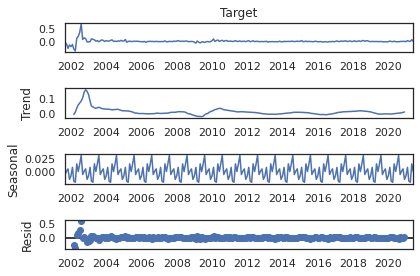

In [ ]:
decomp_results=seasonal_decompose(df['Target'], period=12)
decomp_results.plot()
plt.show()

## Feature correlation

In [ ]:
var_corr=(df.corr()).sort_values('Target')
var_corr

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
u_mom_ch,-0.003714,-0.034579,-0.063796,-0.024506,-0.063796,-0.063796,-0.087303,0.053362,-0.051776,1.000000
orders_mom_ch,0.027438,0.042343,0.076665,-0.025412,0.076665,0.076665,0.022753,1.000000,-0.021730,0.053362
market6,0.031466,0.403794,0.418639,1.000000,0.418639,0.418639,-0.014017,-0.025412,0.169120,-0.024506
ipr_mom_ch,0.065917,0.207863,0.110387,-0.014017,0.110387,0.110387,1.000000,0.022753,0.209631,-0.087303
inventory_mom_ch,0.084168,0.181002,0.188004,0.169120,0.188004,0.188004,0.209631,-0.021730,1.000000,-0.051776
market3,0.101676,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796
market12,0.101676,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796
market18,0.101676,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796
market1,0.122381,1.000000,0.603675,0.403794,0.603675,0.603675,0.207863,0.042343,0.181002,-0.034579
Target,1.000000,0.122381,0.101676,0.031466,0.101676,0.101676,0.065917,0.027438,0.084168,-0.003714


Correlation map

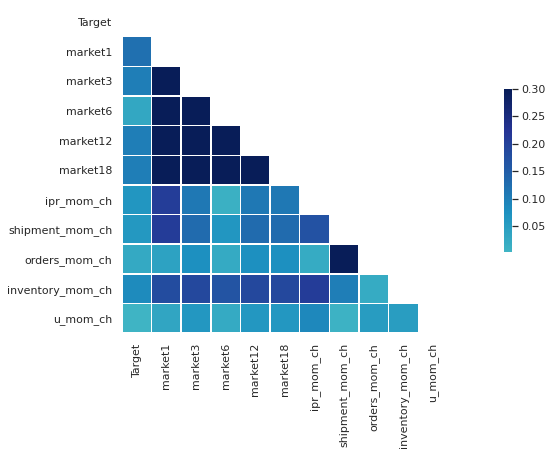

In [ ]:
sns.set_theme(style="white")
corr=df.corr()
f, ax=plt.subplots(figsize=(20,6))
cmap=sns.diverging_palette(250, 20, as_cmap=True)
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(abs(corr), cmap="YlGnBu", 
            mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Delete shipment & inventory

In [ ]:
df=df.drop(['shipment_mom_ch'],axis=1)
df.head()

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch
Date,,,,,,,,,,
2001-09-01,-0.035183,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714
2001-10-01,-0.094375,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667
2001-11-01,-0.264241,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258
2001-12-01,-0.131840,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162
2002-01-01,-0.198061,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254


## Shift target variable by 1, 3, 6, 12, 18 months

In [ ]:
df_1 = df
df_1 = df_1.reset_index()
df_1['Target'] = df_1.Target.shift(-1)
df_1['Date'] = df_1.Date + pd.DateOffset(months = 1)
df_1 = df_1.set_index('Date')
df_1 = df_1[df_1.index >= Target.index[0]]
df_1['Month'] = df_1.index.month
df_1

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Date,,,,,,,,,,,
2001-10-01,-0.094375,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714,10
2001-11-01,-0.264241,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667,11
2001-12-01,-0.131840,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258,12
2002-01-01,-0.198061,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162,1
2002-02-01,-0.112940,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254,2
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,0.003806,0.023037,0.342372,-0.060056,0.342372,0.342372,0.002132,0.002289,0.002105,0.000000,10
2020-11-01,0.010316,0.013084,0.160532,-0.113598,0.160532,0.160532,0.002956,0.023546,-0.000175,-0.482759,11
2020-12-01,0.002434,0.009809,0.027331,0.227182,0.027331,0.027331,0.002956,0.000992,0.002076,0.292683,12


In [ ]:
df_3=df
df_3=df_3.reset_index()
df_3['Target']=df_3['Target'].shift(-3)
df_3['Date']=df_3['Date']+ pd.DateOffset(months = 3)
df_3=df_3.set_index('Date')
df_3 = df_3[df_3.index >= target.index[0]]
df_3['Month']=df_3.index.month
df_3

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Date,,,,,,,,,,,
2001-12-01,-0.131840,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714,12
2002-01-01,-0.198061,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667,1
2002-02-01,-0.112940,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258,2
2002-03-01,-0.292307,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162,3
2002-04-01,-0.366633,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254,4
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,0.002434,0.023037,0.342372,-0.060056,0.342372,0.342372,0.002132,0.002289,0.002105,0.000000,12
2021-01-01,-0.000057,0.013084,0.160532,-0.113598,0.160532,0.160532,0.002956,0.023546,-0.000175,-0.482759,1
2021-02-01,NaN,0.009809,0.027331,0.227182,0.027331,0.027331,0.002956,0.000992,0.002076,0.292683,2


In [ ]:
df_6=df
df_6=df_6.reset_index()
df_6['Target']=df_6['Target'].shift(-6)
df_6['Date']=df_6['Date']+ pd.DateOffset(months = 6)
df_6=df_6.set_index('Date')
df_6 = df_6[df_6.index >= target.index[0]]
df_6['Month']=df_6.index.month
df_6

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Date,,,,,,,,,,,
2002-03-01,-0.292307,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714,3
2002-04-01,-0.366633,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667,4
2002-05-01,0.133001,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258,5
2002-06-01,0.199389,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162,6
2002-07-01,0.359578,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254,7
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,NaN,0.023037,0.342372,-0.060056,0.342372,0.342372,0.002132,0.002289,0.002105,0.000000,3
2021-04-01,NaN,0.013084,0.160532,-0.113598,0.160532,0.160532,0.002956,0.023546,-0.000175,-0.482759,4
2021-05-01,NaN,0.009809,0.027331,0.227182,0.027331,0.027331,0.002956,0.000992,0.002076,0.292683,5


In [ ]:
df_12=df
df_12=df_12.reset_index()
df_12['Target']=df_12['Target'].shift(-12)
df_12['Date']=df_12['Date']+ pd.DateOffset(months = 12)
df_12=df_12.set_index('Date')
df_12 = df_12[df_12.index >= target.index[0]]
df_12['Month']=df_12.index.month
df_12

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Date,,,,,,,,,,,
2002-09-01,0.083570,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714,9
2002-10-01,0.144311,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667,10
2002-11-01,0.114729,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258,11
2002-12-01,-0.013632,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162,12
2003-01-01,-0.013019,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,NaN,0.023037,0.342372,-0.060056,0.342372,0.342372,0.002132,0.002289,0.002105,0.000000,9
2021-10-01,NaN,0.013084,0.160532,-0.113598,0.160532,0.160532,0.002956,0.023546,-0.000175,-0.482759,10
2021-11-01,NaN,0.009809,0.027331,0.227182,0.027331,0.027331,0.002956,0.000992,0.002076,0.292683,11


In [ ]:
df_18=df
df_18=df_18.reset_index()
df_18['Target']=df_18['Target'].shift(-18)
df_18['Date']=df_18['Date']+ pd.DateOffset(months = 18)
df_18=df_18.set_index('Date')
df_18 = df_18[df_18.index >= target.index[0]]
df_18['Month']=df_18.index.month
df_18

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Date,,,,,,,,,,,
2003-03-01,0.102729,-0.450016,-0.223276,-0.443436,-0.223276,-0.223276,-0.002268,-0.050116,-0.034466,0.035714,3
2003-04-01,0.087681,-0.414976,-0.050709,-0.613667,-0.050709,-0.050709,-0.003411,-0.012251,-0.023644,0.066667,4
2003-05-01,0.067519,-0.242129,-0.468662,-0.180843,-0.468662,-0.468662,-0.003411,0.007560,-0.021003,0.032258,5
2003-06-01,0.014086,-0.608143,-0.405413,-0.165990,-0.405413,-0.405413,-0.003411,0.009572,-0.046035,0.162162,6
2003-07-01,0.036401,-0.612288,-0.290757,-0.090202,-0.290757,-0.290757,0.000202,-0.124712,0.002530,-0.042254,7
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,NaN,0.023037,0.342372,-0.060056,0.342372,0.342372,0.002132,0.002289,0.002105,0.000000,3
2022-04-01,NaN,0.013084,0.160532,-0.113598,0.160532,0.160532,0.002956,0.023546,-0.000175,-0.482759,4
2022-05-01,NaN,0.009809,0.027331,0.227182,0.027331,0.027331,0.002956,0.000992,0.002076,0.292683,5


# Model

## SARIMAX Model 1 month horizon

Test correlation

In [ ]:
var_corr_1 = (df_1.corr())
var_corr_1

,Target,market1,market3,market6,market12,market18,ipr_mom_ch,orders_mom_ch,inventory_mom_ch,u_mom_ch,Month
Target,1.000000,0.107354,0.111570,0.076131,0.111570,0.111570,0.117401,0.009730,0.130585,-0.016116,0.035443
market1,0.107354,1.000000,0.603675,0.403794,0.603675,0.603675,0.207863,0.042343,0.181002,-0.034579,0.033678
market3,0.111570,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796,0.027330
market6,0.076131,0.403794,0.418639,1.000000,0.418639,0.418639,-0.014017,-0.025412,0.169120,-0.024506,-0.051356
market12,0.111570,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796,0.027330
market18,0.111570,0.603675,1.000000,0.418639,1.000000,1.000000,0.110387,0.076665,0.188004,-0.063796,0.027330
ipr_mom_ch,0.117401,0.207863,0.110387,-0.014017,0.110387,0.110387,1.000000,0.022753,0.209631,-0.087303,0.002299
orders_mom_ch,0.009730,0.042343,0.076665,-0.025412,0.076665,0.076665,0.022753,1.000000,-0.021730,0.053362,0.027651
inventory_mom_ch,0.130585,0.181002,0.188004,0.169120,0.188004,0.188004,0.209631,-0.021730,1.000000,-0.051776,0.019062
u_mom_ch,-0.016116,-0.034579,-0.063796,-0.024506,-0.063796,-0.063796,-0.087303,0.053362,-0.051776,1.000000,0.000978


Use rfe to select key independent variables that have higher relevance with the target variable (not adopted)

In [ ]:
'''X=df_1.drop(['Target','Month','market1','market3','market6','market12','market18'],axis=1)
y=df_1['Target']
feature_names=X.columns.values
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(LinearRegression(), 
          n_features_to_select=3, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X,y)
feature_names[rfe.get_support()]'''

"X=df_1.drop(['Target','Month','market1','market3','market6','market12','market18'],axis=1)\ny=df_1['Target']\nfeature_names=X.columns.values\nfrom sklearn.feature_selection import RFE\nfrom sklearn.linear_model import LinearRegression\nrfe = RFE(LinearRegression(), \n          n_features_to_select=3, # number of feature to retain\n          step=1 # number of features to eliminate each round\n         ).fit(X,y)\nfeature_names[rfe.get_support()]"

In [ ]:
model_exvar=['ipr_mom_ch', 'orders_mom_ch', 'u_mom_ch', 'market1']

split_date=pd.Timestamp('2017-01-01')

train=df_1.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_1.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [ ]:
results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  184
Model:             SARIMAX(0, 0, 4)x(1, 1, [1], 12)   Log Likelihood                 233.139
Date:                              Tue, 31 Aug 2021   AIC                           -444.277
Time:                                      12:36:41   BIC                           -409.655
Sample:                                  10-01-2001   HQIC                          -430.230
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ipr_mom_ch       -2.9946      3.405     -0.879      0.379      -9.669       3.679
orders_mom

In [ ]:
sar1_model=SARIMAX(y_train, 
                order=(0,0,4), 
                seasonal_order=(1,1,[1],12)
                , exog=X_train
                )

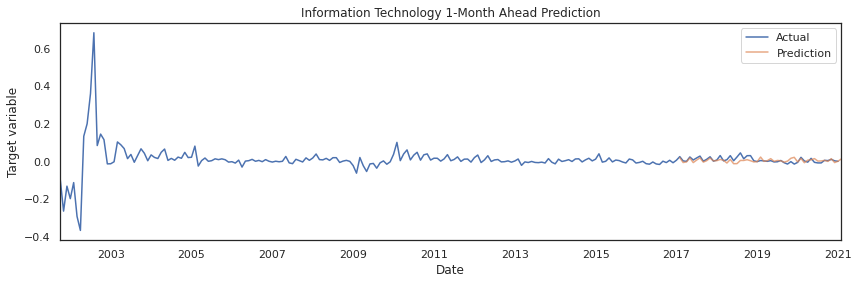

MAE: 0.011


In [ ]:
sar1_mod_fit = sar1_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = X_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.Target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

#print("MAPE:", round(mape(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))

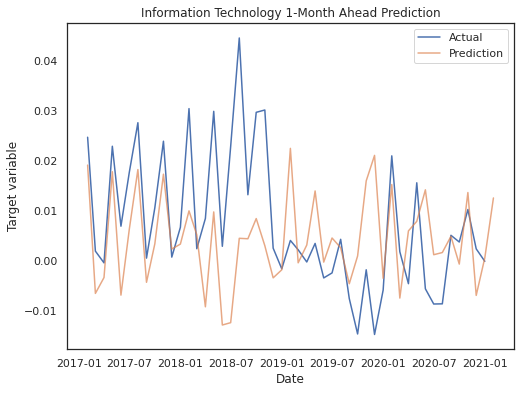

In [ ]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_1[df_1.index >= first_date].index, df_1[df_1.index >= first_date].Target, label = 'Actual')
ax.plot(sar1_pred_mean.index, sar1_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 1-Month Ahead Prediction')
plt.legend()
plt.show()

Performance Matrix

## SARIMAX Model 3 Month Horizon

In [ ]:
model_exvar=['ipr_mom_ch', 'orders_mom_ch', 'u_mom_ch', 'market3']

split_date=pd.Timestamp('2017-01-01')

train=df_3.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_3.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [ ]:
#results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
#print(results.summary())

In [ ]:
sar3_model=SARIMAX(y_train, 
                order=(0,0,3), 
                seasonal_order=(0,1,[1, 2],12)
                , exog=X_train
                )

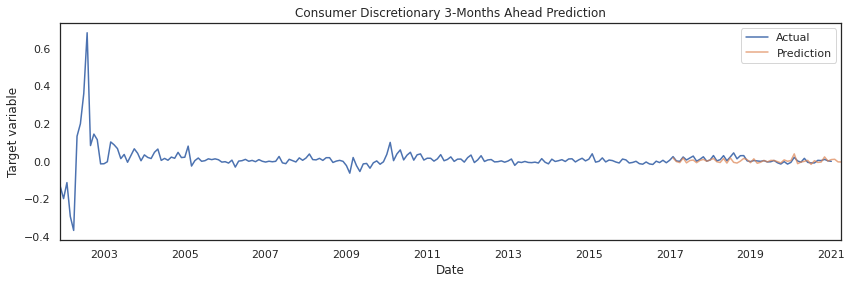

MAE: 0.01


In [ ]:
sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = X_test)
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.Target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Consumer Discretionary 3-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

#print("MAPE:", round(mape(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))

Performance Matrix

## SARIMAX Model 6 month horizon

In [ ]:
model_exvar=['ipr_mom_ch', 'orders_mom_ch', 'u_mom_ch', 'market6']

split_date=pd.Timestamp('2017-01-01')

train=df_6.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_6.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [ ]:
#results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
#print(results.summary())

In [ ]:
sar6_model=SARIMAX(y_train, 
                order=(1,0,0), 
                seasonal_order=(0,1,[1,2],12)
                , exog=X_train
                )

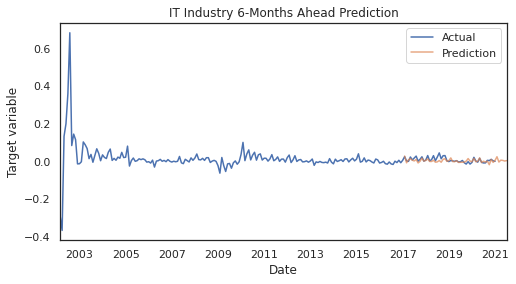

MAE: 0.009


In [ ]:
sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = X_test)
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.Target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(8, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('IT Industry 6-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

#print("MAPE:", round(mape(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))

## SARIMAX Model 12 month horizon

In [ ]:
model_exvar=['ipr_mom_ch', 'orders_mom_ch', 'u_mom_ch', 'market12']

split_date=pd.Timestamp('2017-01-01')

train=df_12.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_12.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [ ]:
#results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
#print(results.summary())

In [ ]:
sar12_model=SARIMAX(y_train, 
                order=(0,0,1), 
                seasonal_order=(0,1,1,12)
                , exog=X_train
                )

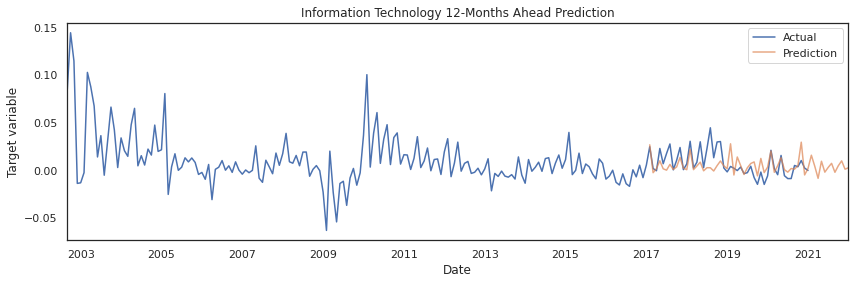

MAE: 0.009


In [ ]:
sar12_mod_fit = sar12_model.fit()
sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = X_test)
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.Target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

#print("MAPE:", round(mape(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))

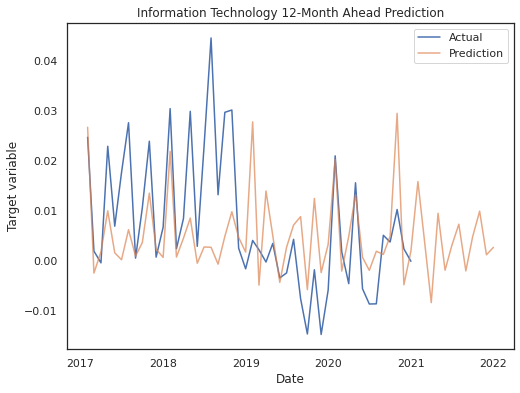

In [ ]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_12[df_12.index >= first_date].index, df_12[df_12.index >= first_date].Target, label = 'Actual')
ax.plot(sar12_pred_mean.index, sar12_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 12-Month Ahead Prediction')
plt.legend()
plt.show()

## SARIMAX Model 18 month horizon

In [ ]:
model_exvar=['ipr_mom_ch', 'orders_mom_ch', 'u_mom_ch', 'market18']

split_date=pd.Timestamp('2017-01-01')

train=df_18.loc[:split_date]
y_train=train['Target']
X_train=train[model_exvar]

test=df_18.loc[(split_date + relativedelta(months = 1)):]
y_test=test['Target']
X_test=test[model_exvar]

Find the best p & q, using aic as criteria

In [ ]:
#results=pm.auto_arima(y_train, seasonal=True, m=12, D=1, information_criterion='aic', exogenous=X_train)
#print(results.summary())

In [ ]:
sar18_model=SARIMAX(y_train, 
                order=(3,0,0), 
                seasonal_order=(2,1,[1,2],12)
                , exog=X_train
                )

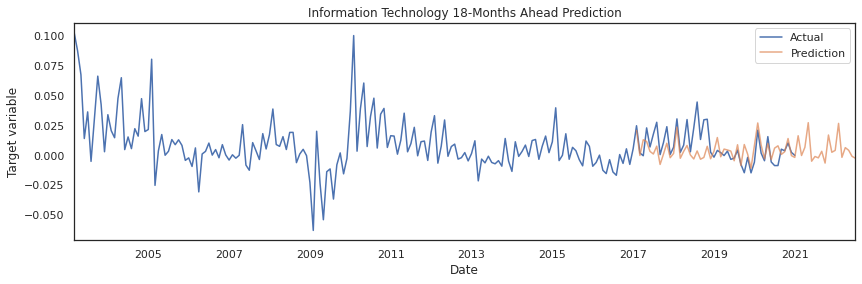

MAE: 0.009


In [ ]:
sar18_mod_fit = sar18_model.fit()
sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = X_test)
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.Target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 18-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

#print("MAPE:", round(mape(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))

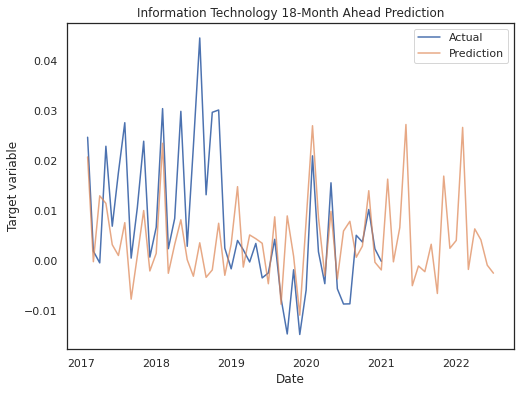

In [ ]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_18[df_18.index >= first_date].index, df_18[df_18.index >= first_date].Target, label = 'Actual')
ax.plot(sar18_pred_mean.index, sar18_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Information Technology 18-Month Ahead Prediction')
plt.legend()
plt.show()

## Future Forecast

In [ ]:
pred18 = pd.DataFrame(sar18_pred_mean).rename(columns = {'predicted_mean' : 'pred18'})
pred18.index = pred18.index.rename('Date')
pred12 = pd.DataFrame(sar12_pred_mean).rename(columns = {'predicted_mean' : 'pred12'})
pred12.index = pred12.index.rename('Date')
pred1 = pd.DataFrame(sar1_pred_mean).rename(columns = {'predicted_mean' : 'pred1'})
pred1.index = pred1.index.rename('Date')

In [ ]:
pred_joined = pred18.join(pred12).join(pred1)
#pred_joined

In [ ]:
pred_joined['combined_pred'] = pred_joined.pred1.fillna(pred_joined.pred12).fillna(pred_joined.pred18)
#pred_joined

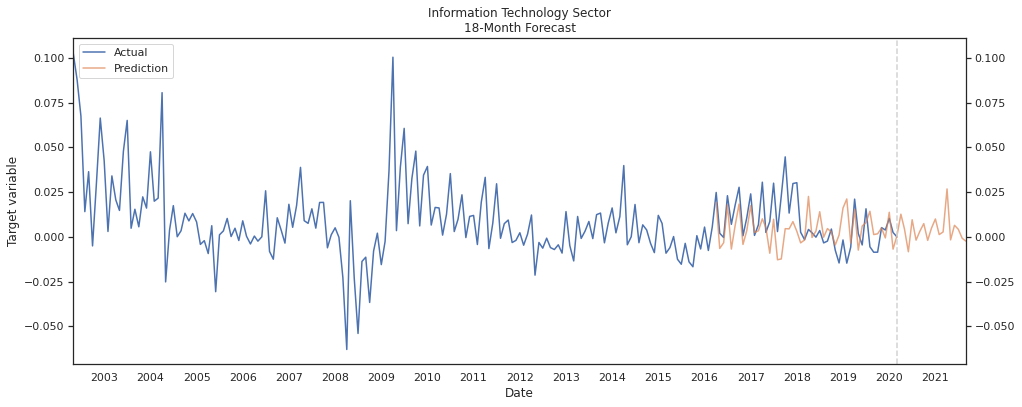

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# plot inputs
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_18.index, df_18.Target, label = 'Actual')
ax.plot(pred_joined.index, pred_joined.combined_pred, label='Prediction', alpha=.7)
ax.axvline(df_18.dropna().index[-1], c = 'lightgrey', linestyle = '--')

# format the axes
ax.xaxis.set_major_formatter(DateFormatter("%Y")) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

ax.yaxis.set_ticks_position('both')
ax.tick_params(length = 5, axis = 'both', labelright = True, direction = 'out')

ax.margins(x=0) # remove whitespace

# labels
ax.set(xlabel = 'Date', ylabel = 'Target variable', 
       title = 'Information Technology Sector\n18-Month Forecast')

plt.legend()
plt.show()